# Advanced features

* File name: advanced_features.ipynb
* Last edited: 2020-06-24
* Created by: Stefan Bruche (TU Berlin)

```python
import copy
import pandas as pd
import aristopy as ar

# Get data from csv-file 
data = pd.read_csv('testdata.csv', sep=';', decimal='.', index_col=[0])

# USER-INPUT: "hpts" (hours per time step)
hpts = 4

# Aggregate data with "hours_per_time_step" for simplification of this notebook
c_elec = ar.utils.aggregate_time_series(data['c_elec [EUR/MWh]'], hpts, 'mean')
q_demand = ar.utils.aggregate_time_series(data['Q_demand [MWh]'], hpts, 'sum')

# Create energy system instance
es = ar.EnergySystem(
    number_of_time_steps=8760//hpts, hours_per_time_step=hpts,
    interest_rate=0.05, economic_lifetime=20, logging=ar.Logger(
        default_log_handler='file', default_log_level='INFO', 
        write_screen_output_to_logfile=True))

# Add a gas source, a heat and electricity sink and a heat bus for collecting
gas_source = ar.Source(
    ensys=es, name='gas_source', commodity_cost=20, outlet=ar.Flow('Fuel'))

heat_sink = ar.Sink(
    ensys=es, name='heat_sink', inlet=ar.Flow('Heat', link='heat_bus'),
    commodity_rate_fix=ar.Series('q_demand', q_demand))

elec_sink = ar.Sink(
    ensys=es, name='elec_sink', inlet=ar.Flow('Elec'),
    commodity_revenues=ar.Series('c_elec', c_elec))

heat_bus = ar.Bus(
    ensys=es, name='heat_bus',
    inlet=ar.Flow('Heat', var_name='Heat_inlet'),
    outlet=ar.Flow('Heat', var_name='Heat_outlet'))

gas_boiler = ar.Conversion(
    ensys=es, name='gas_boiler', basic_variable='Heat',
    inlet=ar.Flow('Fuel', 'gas_source'), outlet=ar.Flow('Heat', 'heat_bus'),
    capacity_max=250, capex_per_capacity=60e3,
    user_expressions='Heat == 0.9 * Fuel')

# Add a group of 5 gas engine units with fixed size
gas_engine = ar.Conversion(
    ensys=es, name='gas_engine', basic_variable='Elec',
    inlet=ar.Flow('Fuel', 'gas_source'),
    outlet=[ar.Flow('Heat', 'heat_bus'), ar.Flow('Elec', 'elec_sink')],
    has_existence_binary_var=True, has_operation_binary_var=True,
    additional_vars=ar.Var('Load', ub=1), scalar_params={'dt': hpts},
    capacity=20, min_load_rel=0.2,
    user_expressions=['Load <= BI_OP',
                      'Elec == (20 * Load) * dt',
                      'Heat <= (17 * Load + 2.5 * BI_OP) * dt',
                      'Fuel == (37 * Load + 7 * BI_OP) * dt'],
    capex_per_capacity=1000e3, opex_per_capacity=12.5e3, opex_operation=6,
    instances_in_group=5)

# Add a heat storage component
heat_storage = ar.Storage(
    ensys=es, name='heat_storage',
    inlet=ar.Flow('Heat', link='heat_bus', var_name='Heat_charge'),
    outlet=ar.Flow('Heat', link='heat_bus', var_name='Heat_discharge'),
    has_existence_binary_var=True,
    maximal_module_number=5, capacity_per_module=50,  # max: 5 * 50 MWh
    capex_per_capacity=12e3, opex_per_capacity=0.015*12e3,  # 12,000 €/MWh CAPEX
    self_discharge=0.01, charge_rate=1/6, discharge_rate=1/6,
    opex_operation=1e-9, use_inter_period_formulation=False)

# Use a backdoor to the pyomo model instance and add a user-defined constraint
# specifying the installed nominal thermal capacity needs to be at least 220 MW.
def minimal_installed_capacity_heat(ensys, m):
    expr = 0
    for comp in ensys.components.values():
        if comp.name == 'gas_boiler':
            expr += comp.block.CAP
        elif comp.group_name == 'gas_engine':
            expr += 19.5 * comp.block.BI_EX
    return expr >= 220
es.add_constraint(name='min_cap_heat', has_time_set=False,
                  rule=minimal_installed_capacity_heat)


# Create a deepcopy of the original (full scale) model instance for later use
original_model = copy.deepcopy(es)


# Conventional optimization:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
# Run the optimization of the original model instance
es.optimize(solver='gurobi', time_limit=60, optimization_specs='mipgap=5e-3')


# Time series clustering:
# ~~~~~~~~~~~~~~~~~~~~~~~
# Cluster time series data to 20 typical days.
es.cluster(number_of_typical_periods=20,
           number_of_time_steps_per_period=24//hpts)

# Use aggregated data to run the optimization
es.optimize(use_clustered_data=True)

# Plot results for a single period and scaled to full year with hourly resolution
plotter = ar.Plotter('results.json')
plotter.plot_operation('heat_storage', 'Heat', ylabel='Thermal energy [MWh]',
                       file_name='heat_storage', plot_single_period_with_index=7)
plotter.plot_operation('heat_bus', 'Heat', ylabel='Thermal energy [MWh]', 
                       file_name='heat_bus', scale_to_hourly_resolution=True)

# Two-stage model run:
# ~~~~~~~~~~~~~~~~~~~~
# Construct (declare) a persistent model of the original (full scale) instance
original_model.declare_model(use_clustered_data=False, declare_persistent=True)

# Cluster time series data, declare the model and relax the integrality of the
# binary operation variables
es.cluster(number_of_typical_periods=20,
           number_of_time_steps_per_period=24 // hpts)
es.declare_model(use_clustered_data=True)
es.relax_integrality(include_time_dependent=True, 
                     include_existence=False, include_modules=False)

# Iteratively run the model (1st stage and 2nd stage)
for icc in range(3):

    # Run optimization with clustered data
    es.optimize(use_clustered_data=True, declare_model=False,
                tee=False, results_file=f'1st_stage_results_{icc}.json')

    # Export the configuration to a DataFrame and store it in an Excel-File
    config = es.export_component_configuration(
        write_to_excel=True, file_name=f'1st_stage_config_{icc}.xlsx')

    # Import the optimal configuration and fix design variables
    original_model.import_component_configuration(config)

    # Run the already declared persistent, full scale model
    original_model.optimize(declare_model=False, tee=False,
                            results_file=f'2nd_stage_results_{icc}.json')

    # Reset variables to their original (unfixed) values
    original_model.reset_component_variables()

    # Add an integer-cut constraint for the gas engines to the aggregated model
    # => Exclude previously found optimal design from the solution space
    es.add_design_integer_cut_constraint(which_instances=['gas_engine'])
```

### Data and model

Read the input data from a csv-file for one year in hourly resolution (8760 time steps) with pandas.

In [1]:
# Import the required packages (jupyter magic only required for jupyter notebooks)
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import copy
import pandas as pd
import aristopy as ar

# Get data from csv-file 
data = pd.read_csv('testdata.csv', sep=';', decimal='.', index_col=[0])

In [2]:
# print the first 8 rows
data.head(8)

,c_elec [EUR/MWh],Q_demand [MWh]
01.01.2018 00:00,-5.27,51.828932
01.01.2018 01:00,-29.99,51.123716
01.01.2018 02:00,-56.65,49.202127
01.01.2018 03:00,-63.14,49.060032
01.01.2018 04:00,-64.62,52.669893
01.01.2018 05:00,-67.00,59.055207
01.01.2018 06:00,-72.54,64.771925
01.01.2018 07:00,-76.01,66.424269


Aggregate the data for simplification purposes in this notebook by summing/averaging over 4 hours. There is a built-in function in the file utils.py to assist in completing this task.

In [3]:
# USER-INPUT: "hpts" (hours per time step)
hpts = 4

# Aggregate data with "hours_per_time_step" for simplification of this notebook
c_elec = ar.utils.aggregate_time_series(data['c_elec [EUR/MWh]'], hpts, 'mean')
q_demand = ar.utils.aggregate_time_series(data['Q_demand [MWh]'], hpts, 'sum')

As in the first example, first, an energy system instance must be created as the main model container. This time an additional logger is added to store information about the modeling and solving process in a log-file. Moreover, a gas source and electricity and heat sinks are added.

In [4]:
# Create energy system instance
es = ar.EnergySystem(
    number_of_time_steps=8760//hpts, hours_per_time_step=hpts,
    interest_rate=0.05, economic_lifetime=20, logging=ar.Logger(
        default_log_handler='file', default_log_level='INFO', 
        write_screen_output_to_logfile=True))

# Add a gas source, a heat and electricity sink and a heat bus for collecting
gas_source = ar.Source(
    ensys=es, name='gas_source', commodity_cost=20, outlet=ar.Flow('Fuel'))

heat_sink = ar.Sink(
    ensys=es, name='heat_sink', inlet=ar.Flow('Heat', link='heat_bus'),
    commodity_rate_fix=ar.Series('q_demand', q_demand))

elec_sink = ar.Sink(
    ensys=es, name='elec_sink', inlet=ar.Flow('Elec'),
    commodity_revenues=ar.Series('c_elec', c_elec))

    containing a solution
Using license file C:\Solver\gurobi\win64\bin\gurobi.lic
Set parameter ServerPassword
Set parameter TokenServer to value olymp.energietechnik.tu-berlin.de


The bus component collects all heat flows at the inlet and transports them (with or without losses) to the outlet. 

<div class="alert alert-info">

**Note:** 

The same commodity is present at the inlet and the outlet. Therefore, different names for the created variables must be specified in the corresponding flows.
</div>

In [5]:
heat_bus = ar.Bus(
    ensys=es, name='heat_bus',
    inlet=ar.Flow('Heat', var_name='Heat_inlet'),
    outlet=ar.Flow('Heat', var_name='Heat_outlet'))

gas_boiler = ar.Conversion(
    ensys=es, name='gas_boiler', basic_variable='Heat',
    inlet=ar.Flow('Fuel', 'gas_source'), outlet=ar.Flow('Heat', 'heat_bus'),
    capacity_max=250, capex_per_capacity=60e3,
    user_expressions='Heat == 0.9 * Fuel')

Next, we add five gas engine instances with identical specifications that are simultaneously created and arranged in a group (see "instances_in_group"). The five components can work independently, but have an order for their binary existence and operation variables (see API of the [Conversion class](conversion.rst)).

In [6]:
# Add maximal 5 gas engine units with fixed size
gas_engine = ar.Conversion(
    ensys=es, name='gas_engine', basic_variable='Elec',
    inlet=ar.Flow('Fuel', 'gas_source'),
    outlet=[ar.Flow('Heat', 'heat_bus'), ar.Flow('Elec', 'elec_sink')],
    has_existence_binary_var=True, has_operation_binary_var=True,
    additional_vars=ar.Var('Load', ub=1), scalar_params={'dt': hpts},
    capacity=20, min_load_rel=0.2,
    user_expressions=['Load <= BI_OP',
                      'Elec == (20 * Load) * dt',
                      'Heat <= (17 * Load + 2.5 * BI_OP) * dt',
                      'Fuel == (37 * Load + 7 * BI_OP) * dt'],
    capex_per_capacity=1000e3, opex_per_capacity=12.5e3, opex_operation=6,
    instances_in_group=5)

The performance modeling in the user expressions of the gas engines involves using of binary operating variables (default name "BI_OP" is defined in file utils.py). Due to the y-axis intercept, the resulting efficiency curves show non-linear characteristics.

<div class="alert alert-info">

**Note:** 

If required, we could also introduce time-varying parameters in the user-expressions to describe the dependency of the conversion rates on, e.g., ambient conditions.
</div>

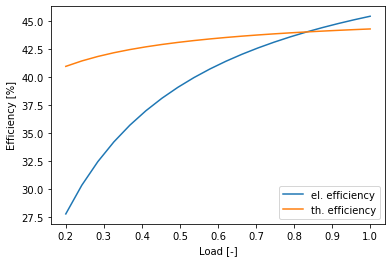

In [7]:
import matplotlib.pyplot as plt
import numpy as np

idx = np.linspace(0.2, 1, 20)
plt.plot(idx, (20*idx)/(37*idx+7)*100, label='el. efficiency')
plt.plot(idx, (17*idx+2.5)/(37*idx+7)*100, label='th. efficiency')
plt.xlabel('Load [-]'), plt.ylabel('Efficiency [%]'), plt.legend(loc=4)
plt.show()

A heat storage component is also included in the design. The storage tank has a modular design and can consist of up to 5 modules of 50 MWh. It should be noted that, similar to the bus component, different variable names must be specified for the inlet and outlet flows. The small value for the argument "opex_operation" is set to prevent simultaneous loading and unloading of the storage. For all other keyword arguments, please consult the documentation of the [storage class API](storage.rst).

In [8]:
# Add a heat storage component
heat_storage = ar.Storage(
    ensys=es, name='heat_storage',
    inlet=ar.Flow('Heat', link='heat_bus', var_name='Heat_charge'),
    outlet=ar.Flow('Heat', link='heat_bus', var_name='Heat_discharge'),
    has_existence_binary_var=True,
    maximal_module_number=5, capacity_per_module=50,  # max: 5 * 50 MWh
    capex_per_capacity=12e3, opex_per_capacity=0.015*12e3,  # 12,000 €/MWh CAPEX
    self_discharge=0.01, charge_rate=1/6, discharge_rate=1/6,
    opex_operation=1e-9, use_inter_period_formulation=False)

Finally, we introduce a constraint that the total installed thermal capacity of the gas boiler and all gas engines must be at least 220 MW. To add this condition to the model, we use a back door to the main pyomo model instance, accessible via the method "add_constraint" of the energy system. It must be determined whether the constraint is time-dependent (or has a different set), and a function must be assigned as the constraint rule. This function needs to have at least two arguments. The first one represents the energy system instance; the second one is the pyomo model instance. For a time-dependent constraint, we would need to add two more arguments, representing period (p) and time-step (t). <br>
Furthermore, *aristopy* offers the possibility to add additional variables and objective function contributions to the main pyomo model instance. The functions "add_variable" and "add_objective_function_contribution" are available for this purpose. Please consult the API of the [EnergySystem class](energySystem.rst) for further information.

In [9]:
# Use a backdoor to the pyomo model instance and add a user-defined constraint
# specifying the installed nominal thermal capacity needs to be at least 220 MW.
def minimal_installed_capacity_heat(ensys, m):
    expr = 0
    for comp in ensys.components.values():
        if comp.name == 'gas_boiler':
            expr += comp.block.CAP
        elif comp.group_name == 'gas_engine':
            expr += 19.5 * comp.block.BI_EX
    return expr >= 220
es.add_constraint(name='min_cap_heat', has_time_set=False,
                  rule=minimal_installed_capacity_heat)

Before we pass the developed model to a solver, we create a copy using method "deepcopy" of the copy-package. We will use this original model instance later.

In [10]:
# Create a deepcopy of the original (full scale) model instance for later use
original_model = copy.deepcopy(es)

### Conventional optimization

As in the first example, the model can simply be solved by calling the optimze method of the energy system instance. To control the solving process, we add a time limitation in seconds and a requested relative MIP-gap to the solver Gurobi. 

In [11]:
# Run the optimization of the original model instance
es.optimize(solver='gurobi', time_limit=300, optimization_specs='mipgap=1e-3', 
            results_file='full_scale_results.json', tee=False)

In [12]:
# show basic information about the model building and solving process
es.run_info

{'solver_name': 'gurobi',
 'time_limit': 300,
 'optimization_specs': 'mipgap=1e-3',
 'model_build_time': 5,
 'model_solve_time': 310,
 'upper_bound': -163634109.14349702,
 'lower_bound': -163920996.8127097,
 'sense': 'maximize',
 'solver_status': 'aborted',
 'termination_condition': 'maxTimeLimit'}

The optimal design solution of the original (full scale) model instance can be accessed with the "export_component_configuration" method and is stated in the table below. The objective function contributions of the individual components are shown in the following figure.

In [13]:
es.export_component_configuration()

,gas_source,heat_sink,elec_sink,heat_bus,gas_boiler,gas_engine_1,gas_engine_2,gas_engine_3,gas_engine_4,gas_engine_5,heat_storage
BI_EX,None,None,None,None,None,1,1,1,1,-0,1
BI_MODULE_EX,None,None,None,None,None,None,None,None,None,None,"{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: -0.0}"
CAP,None,None,None,None,142,20,20,20,20,0,200


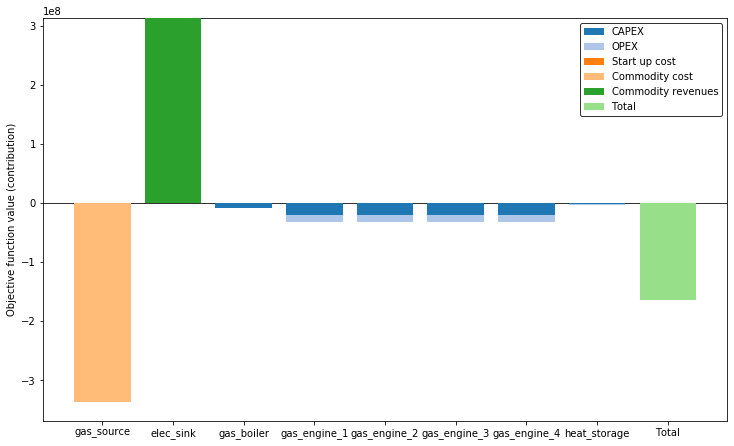

In [14]:
ar.Plotter('full_scale_results.json').plot_objective(show_plot=True)

### Time series clustering

To reduce the number of variables and to speed up the calculation, we can perform the optimization for only a few typical periods. To do this, we first call the "cluster" method and break the time series data into elements of equal length and combine similar items into clusters. In the example below, 20 typical days are formed from the input data, and the optimization is performed with these aggregated data ("use_clustered_data" is True).

In [15]:
# Cluster time series data to 20 typical days.
es.cluster(number_of_typical_periods=20,
           number_of_time_steps_per_period=24//hpts)

# Use clustered data to run the optimization
es.optimize(use_clustered_data=True, tee=False, results_file='clustered_results.json')

The required time to build and solve the model can be reduced significantly by using clustered input data. The optimal design solution found is comparable to the one of the original model.

In [16]:
es.run_info

{'solver_name': 'gurobi',
 'time_limit': None,
 'optimization_specs': '',
 'model_build_time': 0,
 'model_solve_time': 1,
 'upper_bound': -170278358.02702567,
 'lower_bound': -170278358.02702567,
 'sense': 'maximize',
 'solver_status': 'ok',
 'termination_condition': 'optimal'}

In [17]:
es.export_component_configuration()

,gas_source,heat_sink,elec_sink,heat_bus,gas_boiler,gas_engine_1,gas_engine_2,gas_engine_3,gas_engine_4,gas_engine_5,heat_storage
BI_EX,None,None,None,None,None,1,1,1,-0,-0,1
BI_MODULE_EX,None,None,None,None,None,None,None,None,None,None,"{1: 1.0, 2: 1.0, 3: 1.0, 4: -0.0, 5: -0.0}"
CAP,None,None,None,None,161.5,20,20,20,-0,-0,150


The following figures show the state of charge (SOC) of the heat storage tank and the associated loading and unloading operations for a selected typical period. Besides, the heat flows, entering and leaving the heat bus component are plotted scaled to a full year cycle.

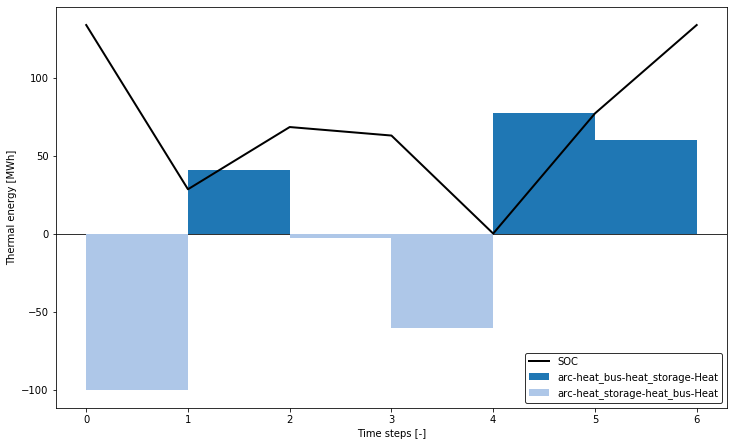

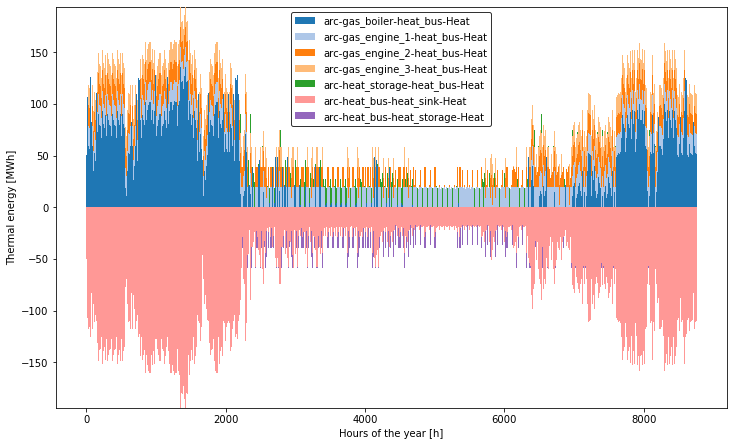

In [18]:
plotter = ar.Plotter('clustered_results.json')
plotter.plot_operation('heat_storage', 'Heat', ylabel='Thermal energy [MWh]',
                       file_name='heat_storage', plot_single_period_with_index=7,
                       show_plot=True)
plotter.plot_operation('heat_bus', 'Heat', ylabel='Thermal energy [MWh]',
                       file_name='heat_bus', scale_to_hourly_resolution=True, 
                       show_plot=True)

### Two-stage model run

The last part of this example shows the possibility of dividing the original problem into two levels to reduce computation time and enable the fast generation of several high-quality design solution candidates.
The developers of *aristopy* have published a comparable method in [this paper](https://doi.org/10.1115/IMECE2019-11519). <br>
In the first optimization stage, a simplified problem is considered, and a design candidate is generated. The simplification is achieved by the aggregation of time series data and the relaxation of binary operation variables. In the second step, the design candidate's objective function value is determined for the original problem by considering the full-scale model.

Building a large optimization model in Pyomo can take a considerable time. Therefore Pyomo offers the possibility to create so-called persistent solvers (only for Gurobi and CPLEX). This solver instance is created only once, and the model is added via its persistent interface. Later, this model can be solved various times without the time-consuming building phase. The flag "declare_persistent" must be set to True during model declaration to exploit these persistent models in *aristopy*. Minor changes can be added to the persistent solver at a later stage. More information about the persistent solver interface of Pyomo can be found [here](https://pyomo.readthedocs.io/en/stable/advanced_topics/persistent_solvers.html).

In [19]:
# Construct (declare) a persistent model of the original (full scale) instance
original_model.declare_model(use_clustered_data=False, declare_persistent=True)

In the following steps, the cluster function is called for the energy system model (not the original/full-scale model!), and the model is declared with aggregated data. Then the binary operating variables (ON/OFF) are relaxed so that they can take on values between zero and one. The existence variables remain binary.

In [20]:
# Cluster time series data, declare the model and the relax integrality of the
# binary operation variables
es.cluster(number_of_typical_periods=20,
           number_of_time_steps_per_period=24//hpts)
es.declare_model(use_clustered_data=True)
es.relax_integrality(include_time_dependent=True,
                     include_existence=False, include_modules=False)

Subsequently, several optimization problems are iteratively solved, and the results are stored in a pandas DataFrame for further comparison. In the first step, the problem is solved with clustered data (model is not declared again!). The configuration (existence and capacity of the components) is imported into the full-scale problem. Now, this original problem is solved with a fixed design as a pure dispatch model. 
In the last step, an integer cut constraint is introduced in the aggregated model. Thus, the current design solution (the combination of binary variables) is excluded from the solution space, and another design solution must be generated in the next model run.

In [21]:
# Create a number of integer-cuts
nbr_of_icc = 5

# Store some results in a DataFrame to compare solutions
results = pd.DataFrame(index=range(nbr_of_icc), columns=[
    'Obj. value [Mio.€]', 'Nbr. of engines [-]', 
    'Capacity storage [MWh]', 'Capacity boiler [MW]', 
    '1st stage time [s]', '2nd stage time [s]'])

for icc in range(nbr_of_icc):

    # Run optimization with clustered data
    es.optimize(use_clustered_data=True, declare_model=False,
                tee=False, results_file=f'1st_stage_results_{icc}.json')

    # Export the configuration to a DataFrame and store it in an Excel-File
    config = es.export_component_configuration(
        write_to_excel=True, file_name=f'1st_stage_config_{icc}.xlsx')

    # Import the optimal configuration and fix design variables
    original_model.import_component_configuration(config)

    # Run the already declared persistent, full scale model
    original_model.optimize(declare_model=False, tee=False,
                            results_file=f'2nd_stage_results_{icc}.json')

    # Reset variables to their original (unfixed) values
    original_model.reset_component_variables()

    # Add an integer-cut constraint for the gas engines to the aggregated model
    # => Exclude previously found optimal design from the solution space
    es.add_design_integer_cut_constraint(which_instances=['gas_engine'])
                                               
    
    results['Obj. value [Mio.€]'].loc[icc] = original_model.run_info['lower_bound'] / 1e6    
    results['Nbr. of engines [-]'].loc[icc] = sum(comp.block.BI_EX.value 
                                                  for comp in es.components.values() 
                                                  if comp.group_name == 'gas_engine')
    results['Capacity storage [MWh]'].loc[icc] = config['heat_storage'].loc['CAP']
    results['Capacity boiler [MW]'].loc[icc] = config['gas_boiler'].loc['CAP']
    results['1st stage time [s]'].loc[icc] = es.run_info['model_solve_time']
    results['2nd stage time [s]'].loc[icc] = original_model.run_info['model_solve_time']

The following summary of the results shows that a single iteration can be performed much faster by splitting it into two optimization levels. The detected solutions are comparable to the globally optimal solution of the original problem (see above). In addition, further design candidates are evaluated and a deeper understanding of the present model is gained.

In [22]:
# print the results on the screen
results

,Obj. value [Mio.€],Nbr. of engines [-],Capacity storage [MWh],Capacity boiler [MW],1st stage time [s],2nd stage time [s]
0,-164.202,3,100,161.5,0,9
1,-166.424,2,100,181,0,4
2,-163.98,4,150,142,0,31
3,-172.912,1,0,200.5,0,1
4,-166.653,5,150,122.5,1,81
